### 라이브러리

In [18]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster
from sklearn import mixture
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

In [116]:
!pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 274.2/274.2 kB 5.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [117]:
from yellowbrick.cluster import SilhouetteVisualizer

### 데이터 불러오기

In [82]:
#m1 = pd.read_csv('장애유형별_연령별_2022/m1.csv', encoding='cp949')
#m2 = pd.read_csv('장애유형별_연령별_2022/m2.csv', encoding='cp949')
#m3 = pd.read_csv('장애유형별_연령별_2022/m3.csv', encoding='cp949')
#m4 = pd.read_csv('장애유형별_연령별_2022/m4.csv', encoding='cp949')
#m5 = pd.read_csv('장애유형별_연령별_2022/m5.csv', encoding='cp949')
# 가장 최근 6월만
m6 = pd.read_csv('장애유형별_연령별_2022/m6.csv', encoding='cp949')
m6

,통계년월,통계시도명,통계시군구명,연령,장애유형,등록장애인수
0,202206,서울특별시,종로구,91,뇌병변,5
1,202206,서울특별시,종로구,59,지체,50
2,202206,서울특별시,종로구,92,뇌병변,1
3,202206,서울특별시,종로구,93,뇌병변,7
4,202206,서울특별시,종로구,94,뇌병변,1
...,...,...,...,...,...,...
162268,202206,제주특별자치도,서귀포시,86,뇌병변,21
162269,202206,제주특별자치도,서귀포시,59,지체,111
162270,202206,제주특별자치도,서귀포시,87,뇌병변,22
162271,202206,제주특별자치도,서귀포시,88,뇌병변,18


In [83]:
#m = pd.concat([m1,m2,m3,m4,m5,m6], ignore_index=True)
#m

In [84]:
mm = m6['통계시도명'] == '서울특별시'
m6df = m6.loc[mm]
m6df

,통계년월,통계시도명,통계시군구명,연령,장애유형,등록장애인수
0,202206,서울특별시,종로구,91,뇌병변,5
1,202206,서울특별시,종로구,59,지체,50
2,202206,서울특별시,종로구,92,뇌병변,1
3,202206,서울특별시,종로구,93,뇌병변,7
4,202206,서울특별시,종로구,94,뇌병변,1
...,...,...,...,...,...,...
21512,202206,서울특별시,강동구,86,뇌병변,21
21513,202206,서울특별시,강동구,59,지체,210
21514,202206,서울특별시,강동구,87,뇌병변,16
21515,202206,서울특별시,강동구,88,뇌병변,13


In [85]:
m6df.isnull().sum()

통계년월      0
통계시도명     0
통계시군구명    0
연령        0
장애유형      0
등록장애인수    0
dtype: int64

### 연령 범주화

In [86]:
def age(x):
    x = (x // 10) * 10
    return x

In [87]:
연령대 = m6df.연령.apply(age)
연령대

0        90
1        50
2        90
3        90
4        90
         ..
21512    80
21513    50
21514    80
21515    80
21516    80
Name: 연령, Length: 21517, dtype: int64

In [88]:
연령대 = 연령대.astype('category')
연령대

0        90
1        50
2        90
3        90
4        90
         ..
21512    80
21513    50
21514    80
21515    80
21516    80
Name: 연령, Length: 21517, dtype: category
Categories (12, int64): [0, 10, 20, 30, ..., 80, 90, 100, 110]

In [89]:
m6df.insert(3, '연령대', 연령대)
m6df

,통계년월,통계시도명,통계시군구명,연령대,연령,장애유형,등록장애인수
0,202206,서울특별시,종로구,90,91,뇌병변,5
1,202206,서울특별시,종로구,50,59,지체,50
2,202206,서울특별시,종로구,90,92,뇌병변,1
3,202206,서울특별시,종로구,90,93,뇌병변,7
4,202206,서울특별시,종로구,90,94,뇌병변,1
...,...,...,...,...,...,...,...
21512,202206,서울특별시,강동구,80,86,뇌병변,21
21513,202206,서울특별시,강동구,50,59,지체,210
21514,202206,서울특별시,강동구,80,87,뇌병변,16
21515,202206,서울특별시,강동구,80,88,뇌병변,13


In [90]:
m6df.장애유형.unique()

array(['뇌병변', '지체', '자폐성', '정신', '신장', '심장', '호흡기', '간', '안면', '장루.요루',
       '뇌전증', '시각', '청각', '언어', '지적'], dtype=object)

### scatter - 전체 데이터 분포 확인

In [91]:
X = m6df.iloc[:, :].values
X[:5]

array([[202206, '서울특별시', '종로구', 90, 91, '뇌병변', 5],
       [202206, '서울특별시', '종로구', 50, 59, '지체', 50],
       [202206, '서울특별시', '종로구', 90, 92, '뇌병변', 1],
       [202206, '서울특별시', '종로구', 90, 93, '뇌병변', 7],
       [202206, '서울특별시', '종로구', 90, 94, '뇌병변', 1]], dtype=object)

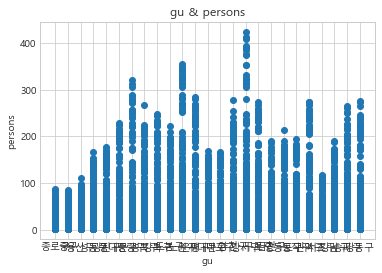

In [93]:
# 구 & 등록장애인 수
plt.scatter(X[:, 2], X[:, 6])
plt.title('gu & persons')
plt.xlabel('gu')
plt.ylabel('persons')
plt.show()

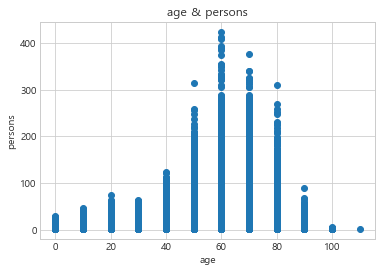

In [94]:
# 연령대 & 등록장애인 수
plt.scatter(X[:, 3], X[:, 6])
plt.title('age & persons')
plt.xlabel('age')
plt.ylabel('persons')
plt.show()

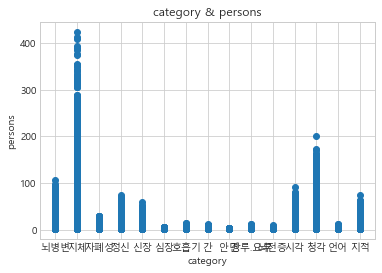

In [95]:
# 장애 유형 & 등록장애인 수
plt.scatter(X[:, 5], X[:, 6])
plt.title('category & persons')
plt.xlabel('category')
plt.ylabel('persons')
plt.show()

### 데이터 시각화 - 축 범위 통일

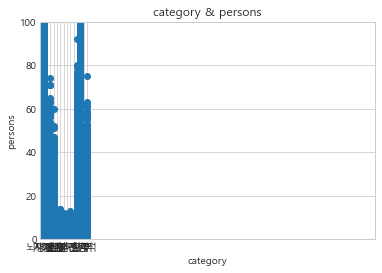

In [96]:
plt.scatter(X[:, 5], X[:, 6])
plt.title('category & persons')
plt.xlabel('category')
plt.xlim(0,100)
plt.ylabel('persons')
plt.ylim(0,100)
plt.show()

### LabelEncoder

In [97]:
le = LabelEncoder()
features = ['통계시군구명']
for f in features:
    m6df[f] = le.fit_transform(m6df[f])
m6df.head()

C:\Users\lynn5\AppData\Local\Temp\ipykernel_20300\1687312950.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m6df[f] = le.fit_transform(m6df[f])


,통계년월,통계시도명,통계시군구명,연령대,연령,장애유형,등록장애인수
0,202206,서울특별시,22,90,91,뇌병변,5
1,202206,서울특별시,22,50,59,지체,50
2,202206,서울특별시,22,90,92,뇌병변,1
3,202206,서울특별시,22,90,93,뇌병변,7
4,202206,서울특별시,22,90,94,뇌병변,1


In [98]:
print(le.classes_)

['강남구' '강동구' '강북구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구' '도봉구' '동대문구' '동작구'
 '마포구' '서대문구' '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구' '용산구' '은평구' '종로구' '중구'
 '중랑구']


In [99]:
le = LabelEncoder()
features = ['장애유형']
for f in features:
    m6df[f] = le.fit_transform(m6df[f])
m6df.head()

C:\Users\lynn5\AppData\Local\Temp\ipykernel_20300\2737439068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m6df[f] = le.fit_transform(m6df[f])


,통계년월,통계시도명,통계시군구명,연령대,연령,장애유형,등록장애인수
0,202206,서울특별시,22,90,91,1,5
1,202206,서울특별시,22,50,59,12,50
2,202206,서울특별시,22,90,92,1,1
3,202206,서울특별시,22,90,93,1,7
4,202206,서울특별시,22,90,94,1,1


In [100]:
print(le.classes_)

['간' '뇌병변' '뇌전증' '시각' '신장' '심장' '안면' '언어' '자폐성' '장루.요루' '정신' '지적' '지체'
 '청각' '호흡기']


In [101]:
m6df.head()

,통계년월,통계시도명,통계시군구명,연령대,연령,장애유형,등록장애인수
0,202206,서울특별시,22,90,91,1,5
1,202206,서울특별시,22,50,59,12,50
2,202206,서울특별시,22,90,92,1,1
3,202206,서울특별시,22,90,93,1,7
4,202206,서울특별시,22,90,94,1,1


In [102]:
df1 = m6df.copy()
df1 = df1.drop(['통계년월', '통계시도명','연령'], axis=1)
df1.head()

,통계시군구명,연령대,장애유형,등록장애인수
0,22,90,1,5
1,22,50,12,50
2,22,90,1,1
3,22,90,1,7
4,22,90,1,1


### 피처 스케일링 (Feature Scaling)

In [103]:
X = df1.iloc[:, :].values
X[:5]

array([[22, 90,  1,  5],
       [22, 50, 12, 50],
       [22, 90,  1,  1],
       [22, 90,  1,  7],
       [22, 90,  1,  1]], dtype=int64)

### Standard Scaler - 표준화

In [104]:
sc = StandardScaler()
X = sc.fit_transform(X)
X[:5]

array([[ 1.43099386,  1.68849296, -1.39386356, -0.36339267],
       [ 1.43099386,  0.08963263,  1.03741111,  0.8844189 ],
       [ 1.43099386,  1.68849296, -1.39386356, -0.47430925],
       [ 1.43099386,  1.68849296, -1.39386356, -0.30793438],
       [ 1.43099386,  1.68849296, -1.39386356, -0.47430925]])

### 데이터 시각화 - 스케일링 데이터

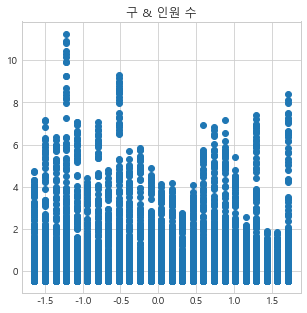

In [105]:
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 3])
plt.title('구 & 인원 수')
plt.show()

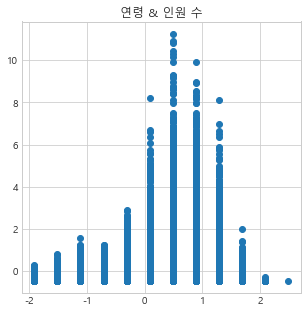

In [106]:
plt.figure(figsize=(5,5))
plt.scatter(X[:, 1], X[:, 3])
plt.title('연령 & 인원 수')
plt.show()

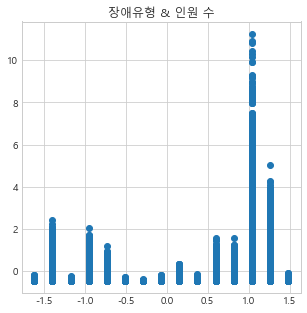

In [107]:
plt.figure(figsize=(5,5))
plt.scatter(X[:, 2], X[:, 3])
plt.title('장애유형 & 인원 수')
plt.show()

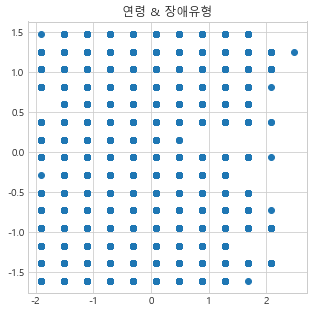

In [108]:
plt.figure(figsize=(5,5))
plt.scatter(X[:, 1], X[:, 2])
plt.title('연령 & 장애유형')
plt.show()

### Elbow Method - K를 찾습니댜

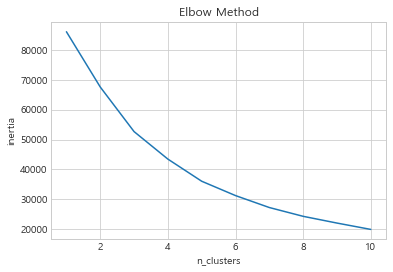

In [109]:
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

#### 당연하게도~~ eblow point 없음! 이럴때 silhouette 계수

### MinMax Scaler -  변수 정규화 - 일단 스탠다드로,,

### Silhouette Score

In [115]:
df2 = pd.DataFrame(data=df1, columns=['통계시군구명','연령대','장애유형','등록장애인수'])
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0)
kmeans.fit(df2)
df2['cluster'] = kmeans.labels_

score_samples = silhouette_samples(df1, df2['cluster'])
print(score_samples.shape)
print(score_samples)
df2['silhoutte_coeff'] = score_samples

average_score = silhouette_score(df1, df2['cluster'])
print(average_score)

(21517,)
[0.5444795  0.33325019 0.55091639 ... 0.51099578 0.54728856 0.57553492]
0.44558586344661094


#### 실루엣 K=2

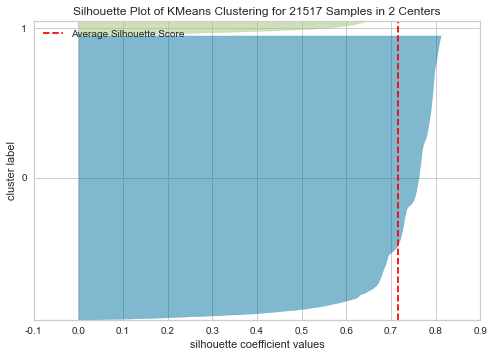

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 21517 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [118]:
#클러스터링 모델 생성
kmeans_2 = KMeans(n_clusters=2, random_state=200,init='random')
#visualizer 생성
visualizer_2 = SilhouetteVisualizer(kmeans_2, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_2.fit(df1)      
visualizer_2.show()

#### 실루엣 K=3

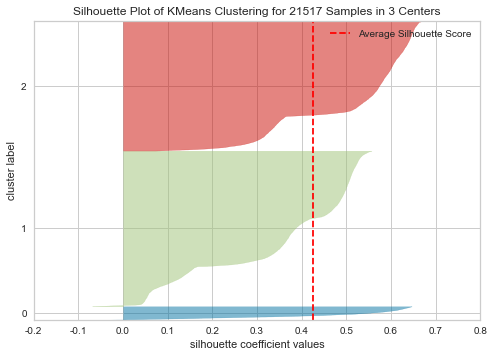

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 21517 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [119]:
kmeans_3 = KMeans(n_clusters=3, random_state=200,init='random')
visualizer_3 = SilhouetteVisualizer(kmeans_3, colors='yellowbrick')
visualizer_3.fit(df1)      
visualizer_3.show()

#### 실루엣 K=4

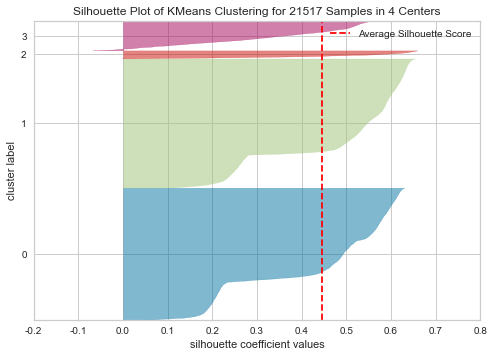

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 21517 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [120]:
kmeans_4 = KMeans(n_clusters=4, random_state=200,init='random')
visualizer_4 = SilhouetteVisualizer(kmeans_4, colors='yellowbrick')
visualizer_4.fit(df1)      
visualizer_4.show()

#### 실루엣 K=5

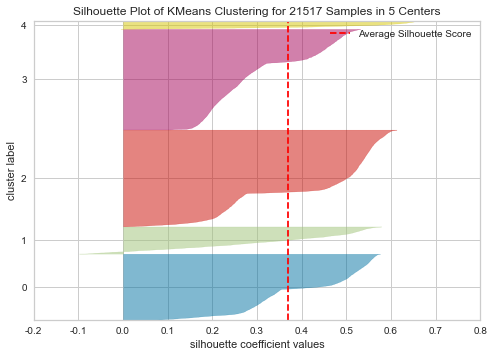

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 21517 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [127]:
kmeans_5 = KMeans(n_clusters=5, random_state=200,init='random')
visualizer_5 = SilhouetteVisualizer(kmeans_5, colors='yellowbrick')
visualizer_5.fit(df1)      
visualizer_5.show()

#### 실루엣 K=6

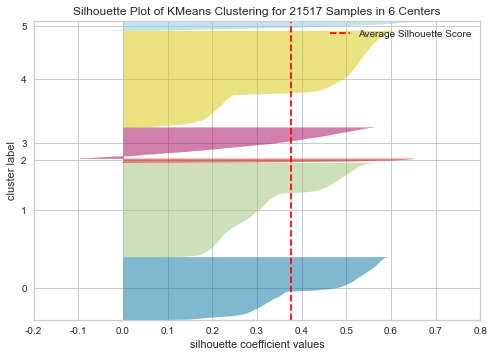

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 21517 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [128]:
kmeans_6 = KMeans(n_clusters=6, random_state=200,init='random')
visualizer_6 = SilhouetteVisualizer(kmeans_6, colors='yellowbrick')
visualizer_6.fit(df1)      
visualizer_6.show()

In [130]:
result_df = df1.copy()

#클러스터ID 컬럼 생성 
result_df.loc[:,'clusterID'] = visualizer_6.predict(df1)
#실루엣 계수 컬럼 생성
result_df.loc[:,'silhouette coefficient'] = visualizer_6.silhouette_samples_

result_df.shape
result_df.head(5)

,통계시군구명,연령대,장애유형,등록장애인수,clusterID,silhouette coefficient
0,22,90,1,5,0,0.528656
1,22,50,12,50,3,0.400295
2,22,90,1,1,0,0.522406
3,22,90,1,7,0,0.526309
4,22,90,1,1,0,0.522406


In [131]:
print('전체 데이터의 실루엣 계수 평균')
result_df['silhouette coefficient'].mean()

print('\n군집별 실루엣 계수 평균')
result_df.groupby('clusterID')['silhouette coefficient'].mean().reset_index()

전체 데이터의 실루엣 계수 평균

군집별 실루엣 계수 평균


,clusterID,silhouette coefficient
0,0,0.422907
1,1,0.329086
2,2,0.482605
3,3,0.299729
4,4,0.406891
5,5,0.418086


In [ ]:
# K=3 이 가장 높네!

### K=3 - KMeans 학습

In [134]:
K = 3

In [136]:
Kmenas = KMeans(n_cluster=3, random_state=0)
y_kmeans = kmeans.fit_predict(df1)

TypeError: __init__() got an unexpected keyword argument 'n_cluster'

In [125]:
# 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [126]:
from sklearn.datasets import make_blobs
X, y = df1(n_samples=500, n_features=2, centers=4, cluster_std=1, \
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)  

# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2, 3, 4, 5], X)

TypeError: 'DataFrame' object is not callable